### Library import

In [1]:
# Library import
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from graphviz import Source
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import MaxNLocator

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"

IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)

os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


### Loading the dataset

In [2]:
# Load the data
# data file is located in folder data
df = pd.read_csv('./data/heart.csv')
print(df.head())
print(df.tail())

   Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N      0.0       Up             0  
1              N      1.0     Flat             1  
2              N      0.0       Up             0  
3              Y      1.5     Flat             1  
4              N      0.0       Up             0  
     Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
913   45   M            TA        110          264          0     Normal   
914   68   M           ASY        144          193     

### Verify for null values and data types of each feature

In [3]:
# Check if the dataset has any missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


### Conversion of categorical variables into numeric values

In [4]:
# Map sex category variable to numeric values
# (0 denote Male and 1 denote Female)
mapping = {'M':0, 'F':1}
df['Sex'] = df['Sex'].replace(mapping)
df.info()
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 86.2+ KB
   Age  Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0           ATA        140          289          0     Normal   
1   49    1           NAP        160          180   

In [5]:
# Find unique values for chest pain type
print(df['ChestPainType'].unique())

['ATA' 'NAP' 'ASY' 'TA']


In [6]:
# Map chest pain type category variable to numeric values
# 0 denote atypical angina (ATA)
# 1 denote non-anginal pain (NAP)
# 2 denote asymptomatic (ASY)
# 3 denote typical angina (TA)
mapping = {'ATA':0, 'NAP':1, 'ASY':2, 'TA':3}
df['ChestPainType'] = df['ChestPainType'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(8), object(3)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  \
0   40    0              0        140          289          0     Normal   
1   49    1              1        160          180

In [7]:
# Find unique values for resting ECG
print(df['RestingECG'].unique())


['Normal' 'ST' 'LVH']


In [8]:
# Map resting ECG category variable to numeric values
# 0 denote Normal
# 1 denote ST-T wave abnormality (ST)
# 2 denote left ventricular hypertrophy (LVH)
mapping = {'Normal':0, 'ST':1, 'LVH':2}
df['RestingECG'] = df['RestingECG'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(9), object(2)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          1

In [9]:
# Map exercise angina category variable to numeric values
# 0 denote No
# 2 denote Yes
mapping = {'N':0, 'Y':1}
df['ExerciseAngina'] = df['ExerciseAngina'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(10), object(1)
memory usage: 86.2+ KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          

In [10]:
# Find unique values for resting ECG
print(df['ST_Slope'].unique())


['Up' 'Flat' 'Down']


In [11]:
# Map resting ECG category variable to numeric values
# 0 denote Up
# 1 denote Flat
# 2 denote Down
mapping = {'Up': 0, 'Flat': 1, 'Down': 2}
df['ST_Slope'] = df['ST_Slope'].replace(mapping)
df.info()
print(df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    int64  
 2   ChestPainType   918 non-null    int64  
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    int64  
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    int64  
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    int64  
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 86.2 KB
   Age  Sex  ChestPainType  RestingBP  Cholesterol  FastingBS  RestingECG  \
0   40    0              0        140          289          0           0   
1   49    1              1        160          180         

### Descriptive statistics

In [12]:
df.describe()


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,0.210240,1.452070,132.396514,198.799564,0.233115,0.603486,136.809368,0.404139,0.887364,0.638344,0.553377
std,9.432617,0.407701,0.851832,18.514154,109.384145,0.423046,0.805968,25.460334,0.490992,1.066570,0.607056,0.497414
min,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,60.000000,0.000000,-2.600000,0.000000,0.000000
25%,47.000000,0.000000,1.000000,120.000000,173.250000,0.000000,0.000000,120.000000,0.000000,0.000000,0.000000,0.000000
50%,54.000000,0.000000,2.000000,130.000000,223.000000,0.000000,0.000000,138.000000,0.000000,0.600000,1.000000,1.000000
75%,60.000000,0.000000,2.000000,140.000000,267.000000,0.000000,1.000000,156.000000,1.000000,1.500000,1.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,603.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,1.000000


### Check for balance dataset

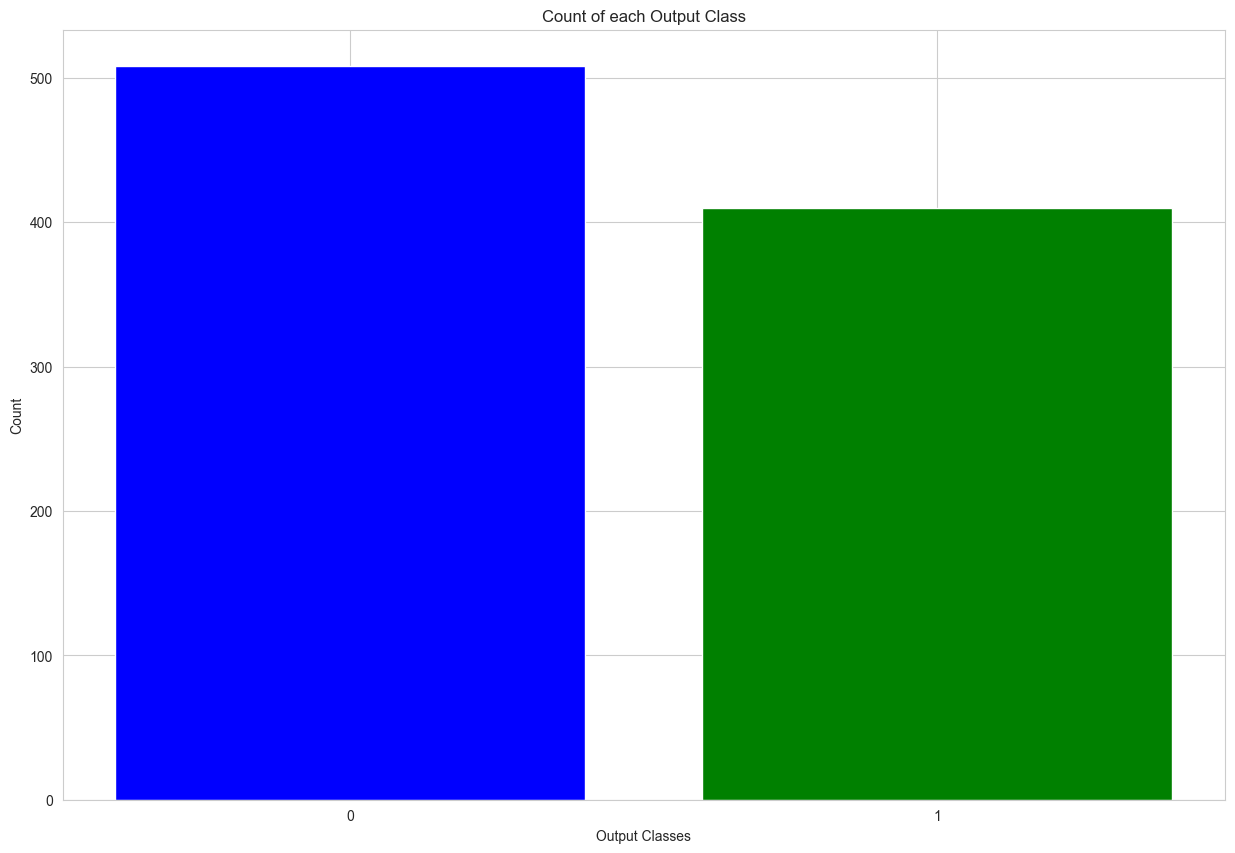

In [13]:
# Check if the dataset is balanced
# Count the number of Heart Disease (1) and Normal (0)
plt.figure(figsize=(15,10))
plt.bar(df['HeartDisease'].unique(), df['HeartDisease'].value_counts(), color = ['blue', 'green'])
plt.xticks([0, 1])
plt.xlabel('Output Classes')
plt.ylabel('Count')
plt.title('Count of each Output Class')
plt.savefig('figures/OutputClassBalance.jpg')

### Correlation matrix among all variables using heatmap

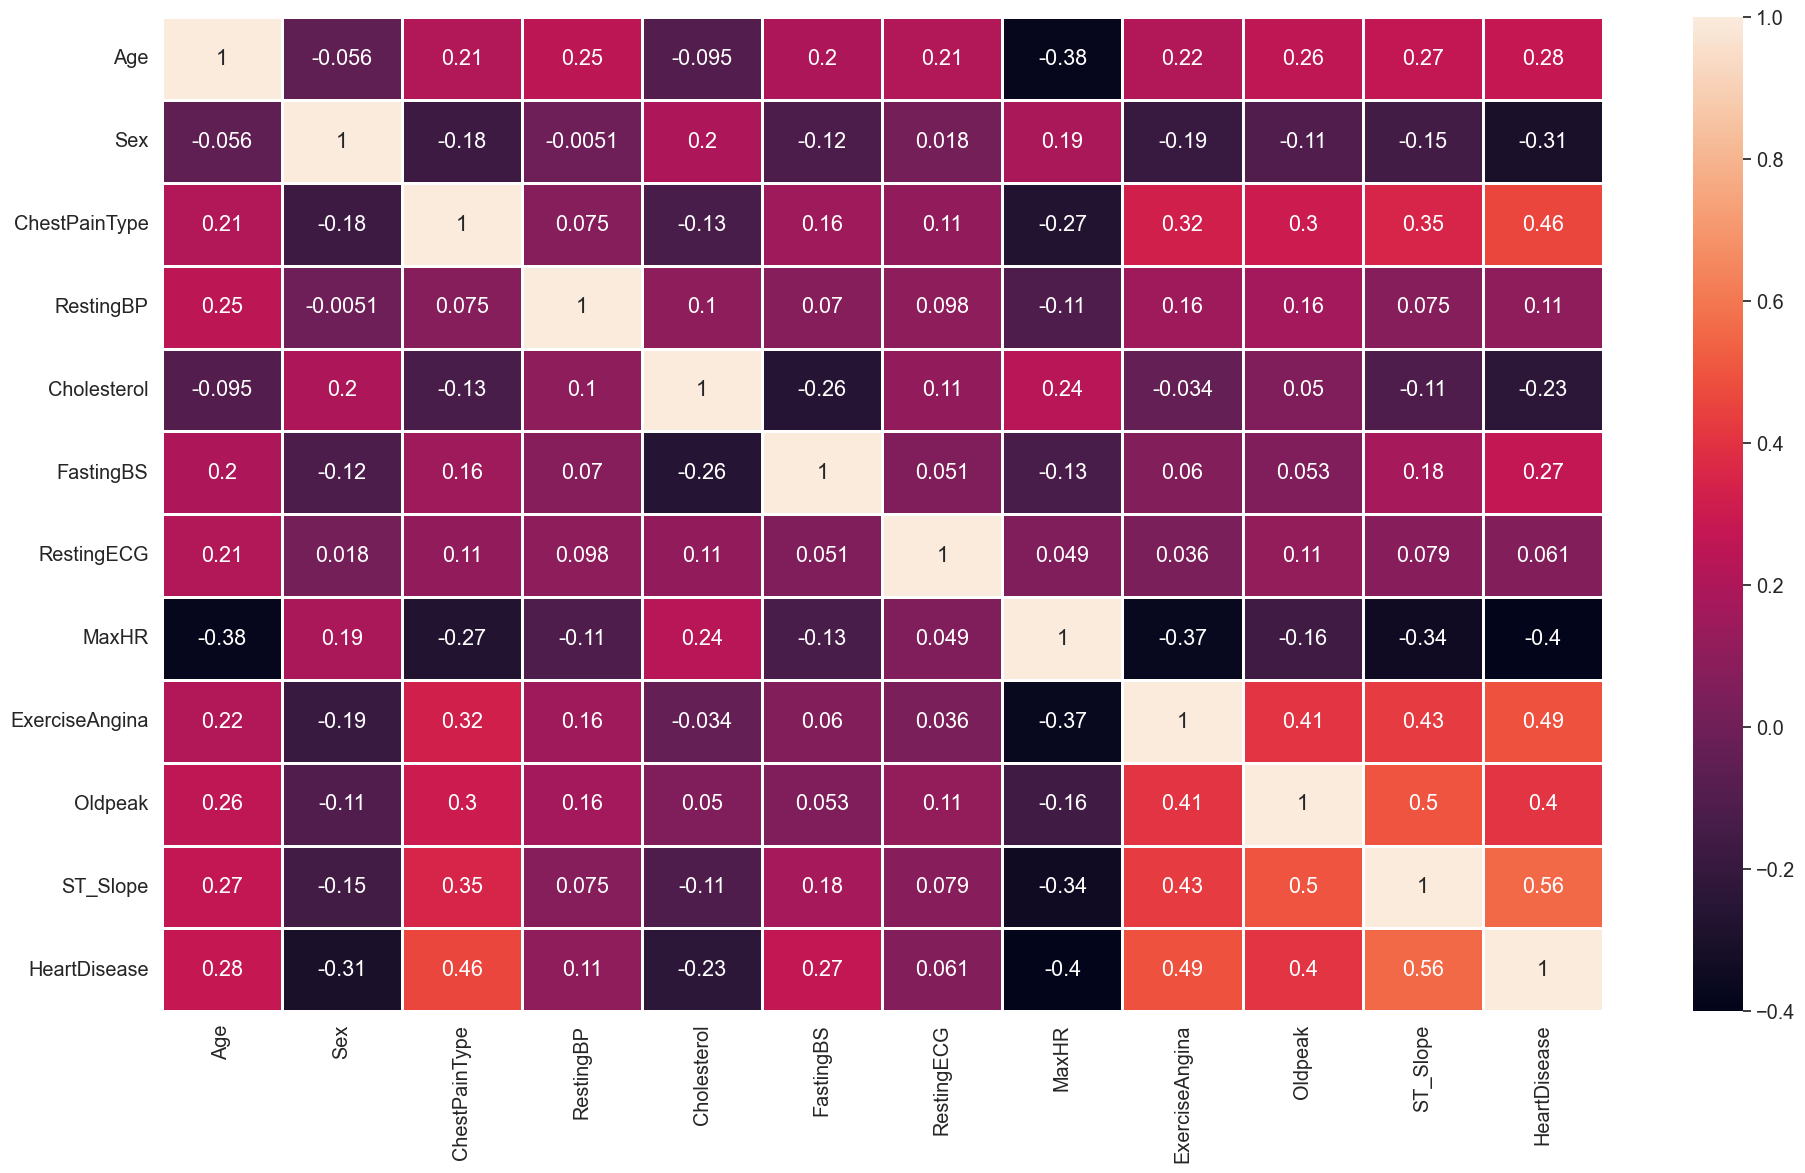

In [14]:
# Generate correlation matrix between all features
plt.figure(figsize=(20,12))
sns.set_context('notebook',font_scale = 1.3)
sns.heatmap(df.corr(),annot=True,linewidth =2)
plt.tight_layout()
plt.savefig('figures/CorrelationMatrix.jpg')

The heatmap shows no significant correlations between each individual variables with the other. Therefore, no features can be a predictor or indicator of the other.

### Uni-variate analysis with the output value

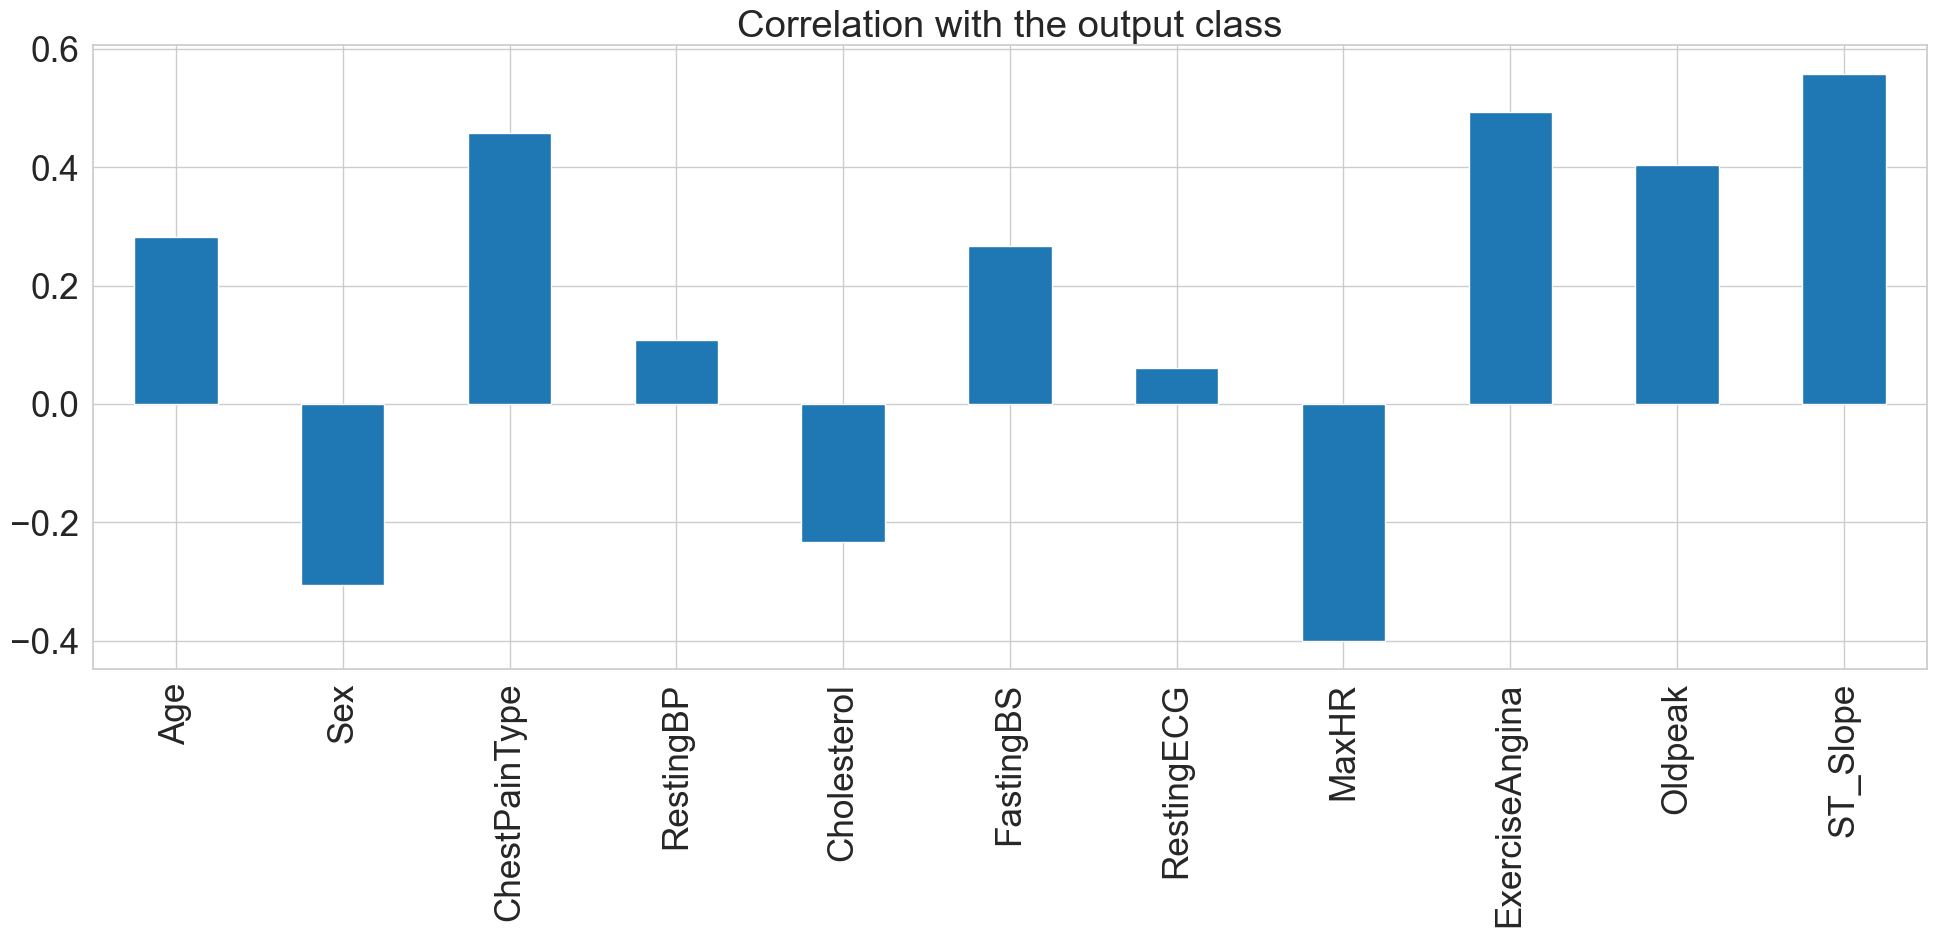

In [15]:
# Identify relationship between each feature and the output class
sns.set_context('notebook',font_scale = 2.3)
df.drop('HeartDisease', axis=1).corrwith(df.HeartDisease).plot(kind='bar', grid=True, figsize=(20, 10), title="Correlation with the output class")
plt.tight_layout()
plt.savefig('figures/OutputCorrelation.jpg')

### Distribution of all features in the given dataset

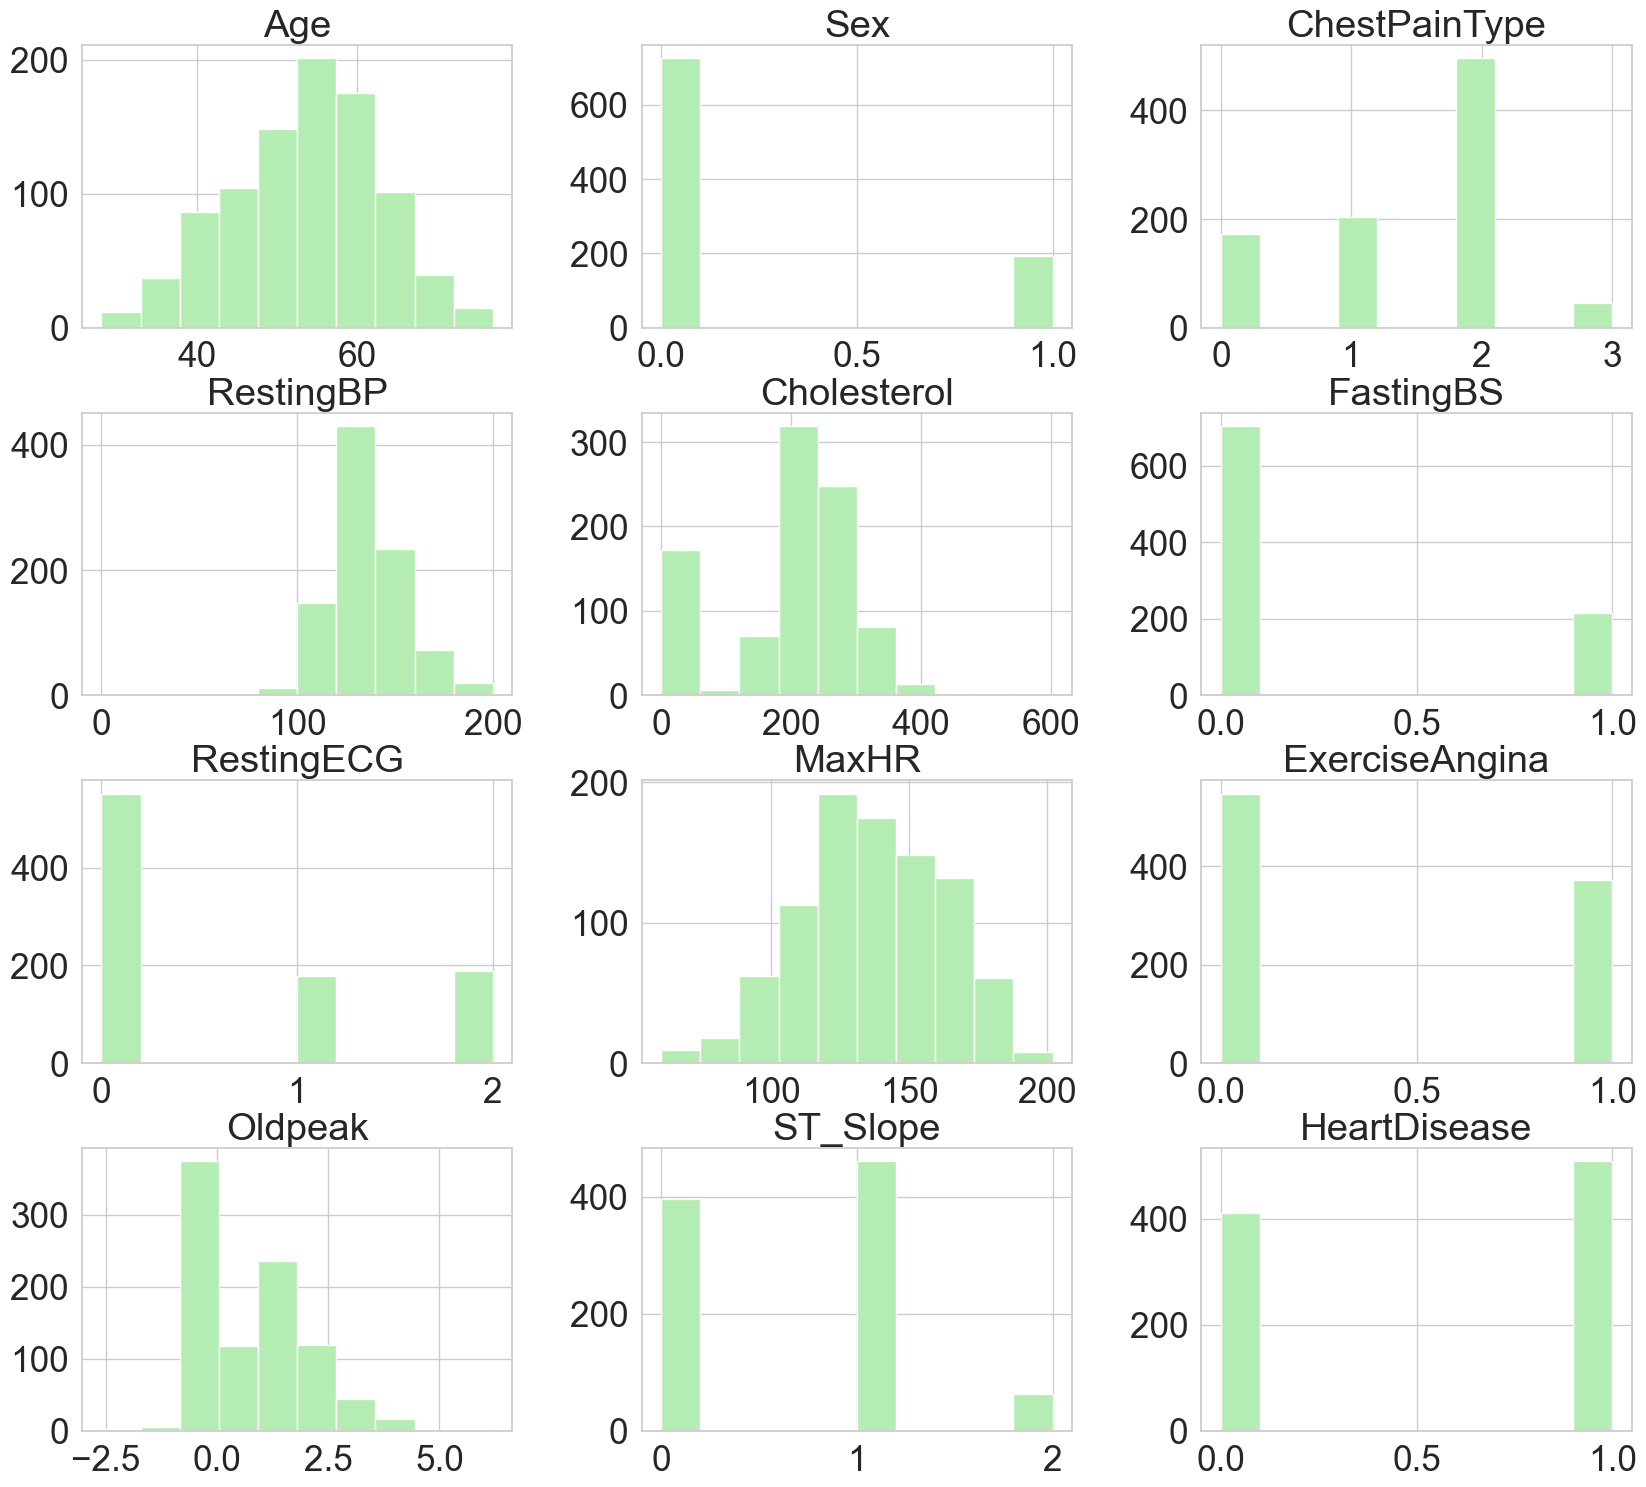

In [16]:
# Find distribution of dataset
df.hist(figsize=(20,18), color = '#B5ECB3')
plt.savefig('figures/HistogramAll.jpg')

A mixture of categorical variables and continuous variables. Continuous variables (age, restingbp, cholesterol, maxhr, oldpeak) need to be scaled since they have different range. Categorical should be divided into dummy columns separating each value.
Another note on the missing value of Cholesterol feature (value = 0): we plan to create 2 models, one with Cholesterol as the feature and the other one without it. We'll then use accuracy to determine if we can drop these missing data tuples.

### Age group analysis using pie charts

<Figure size 4000x4000 with 0 Axes>

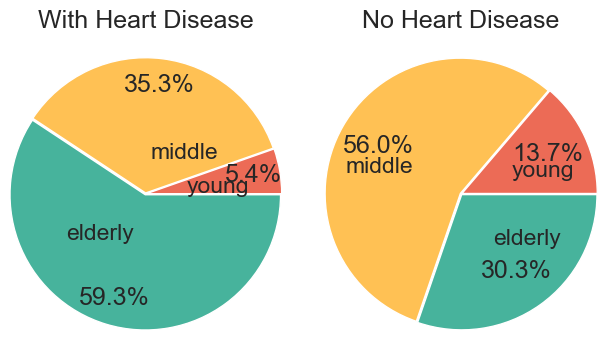

In [17]:
# Plot pie chart for age group vs. heart disease
youngD = df[(df.Age>=28) & (df.Age<40) & (df.HeartDisease==1)]
middleD = df[(df.Age>=40)&(df.Age<55)&(df.HeartDisease==1)]
oldD = df[(df.Age>55)&(df.HeartDisease==1)]

young = df[(df.Age>=28) & (df.Age<40) & (df.HeartDisease==0)]
middle = df[(df.Age>=40)&(df.Age<55)&(df.HeartDisease==0)]
old = df[(df.Age>55)&(df.HeartDisease==0)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(40,40))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(youngD),len(middleD),len(oldD)],labels=['young','middle','elderly'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.8, labeldistance=0.3,center=(0,0))
ax[0].set_title('With Heart Disease', y=1.2, x=0.3)
ax[1].pie([len(young),len(middle),len(old)],labels=['young','middle','elderly'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.4, center=(0.5,0))
ax[1].set_title('No Heart Disease', y=1.2)
plt.savefig('figures/AgeGroupAnalysis.jpg')

The pie chart show that individuals in the elder group (greater than 55) have the highest chance of having heart disease (59.3%). It is then followed by the middle age group between 40 and 55 years old (35.3%) and then younger age group between 28 and 40 years old (5.4%)

Another piece of information from the pie chart with no heart disease, is that middle age and young group combined occupies the majority. This also agrees with the previous finding that the elder group tend to have a high chance of experiencing heart disease.

### Sex analysis using pie chart

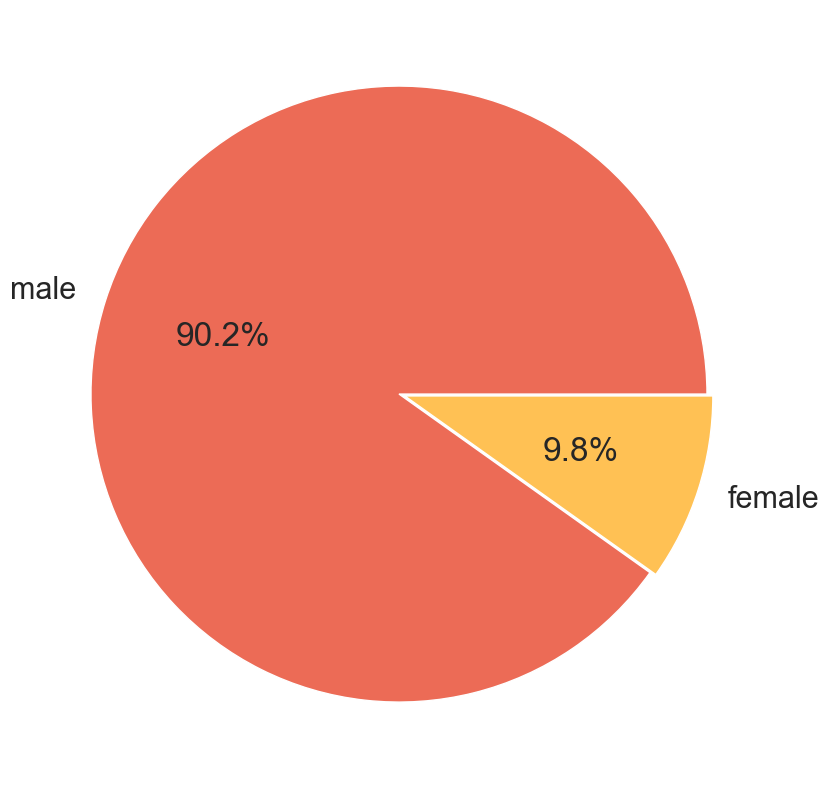

In [18]:
# Plot pie chart for sex vs. heart disease
male = df[(df.Sex==0) & (df.HeartDisease==1)]
female = df[(df.Sex==1)&(df.HeartDisease==1)]

colors = ['#EC6B56','#FFC154']
plt.figure(figsize=(23,10))
sns.set_context('notebook',font_scale = 2)
plt.pie([len(male),len(female)],labels=['male','female'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%')
plt.savefig('figures/SexAnalysis.jpg')

Even though the pie chart shows that the chances of developing heart disease for Male is much higher than Female, we can't establish a strong relationship between the 2 variables. Note that the histogram shows a skewed distribution towards Male, therefore we can't really draw a precise conclusion from the pie chart alone.

### Chest pain type analysis using pie chart

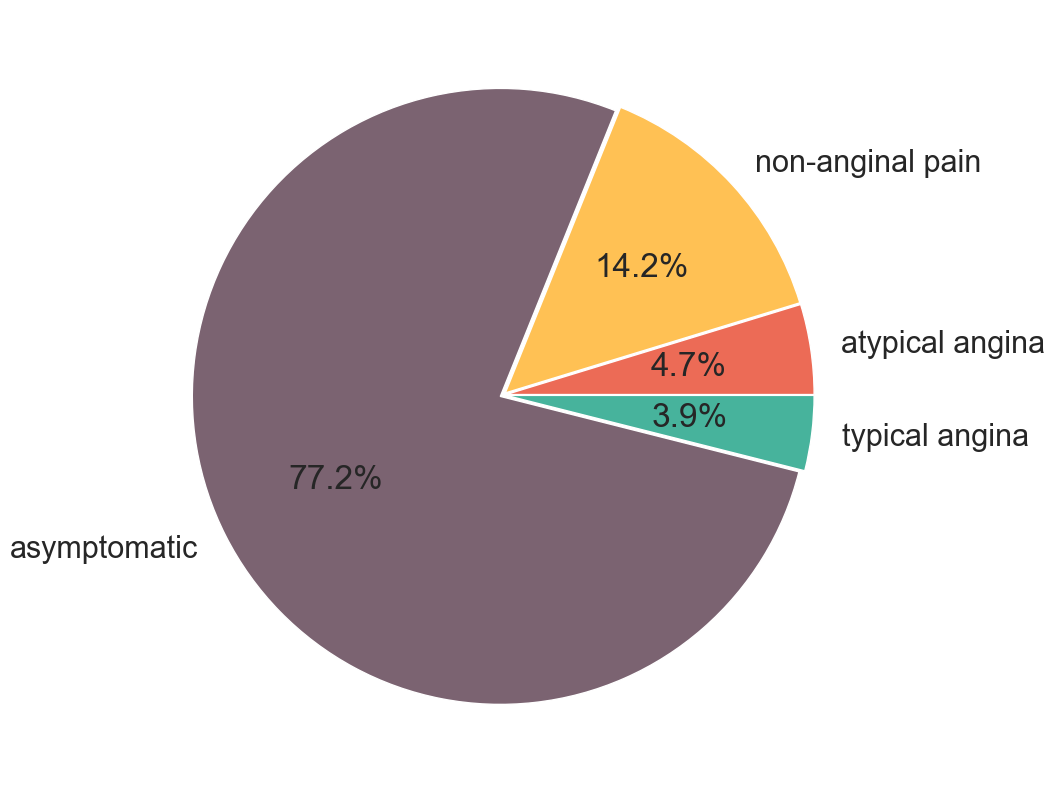

In [19]:
# Plot pie chart for sex vs. heart disease
# 0 denote atypical angina (ATA)
# 1 denote non-anginal pain (NAP)
# 2 denote asymptomatic (ASY)
# 3 denote typical angina (TA)
ata = df[(df.ChestPainType==0) & (df.HeartDisease==1)]
nap = df[(df.ChestPainType==1) & (df.HeartDisease==1)]
asy = df[(df.ChestPainType==2) & (df.HeartDisease==1)]
ta = df[(df.ChestPainType==3) & (df.HeartDisease==1)]

colors = ['#EC6B56','#FFC154','#7b6371', '#47B39C']
plt.figure(figsize=(23,10))
sns.set_context('notebook',font_scale = 2)
plt.pie([len(ata),len(nap), len(asy), len(ta)],labels=['atypical angina','non-anginal pain', 'asymptomatic', 'typical angina'],colors=colors, explode= [0.01,0.01, 0.01, 0.01], autopct='%1.1f%%')
plt.savefig('figures/ChestPainTypeAnalysis.jpg')

The pie chart shows that most patients having heart disease don't experience any significant symptoms. The result agrees with the literature that most heart attacks are silent heart attacks (damage is done, but no symptoms).

In [20]:
# Identify and remove missing values from RestingBP
print("Count of missing values for resting blood pressure (value = 0): ",
      len(df[df['RestingBP'] == 0]))
missingBP = df[df['RestingBP'] == 0]
df.drop(missingBP.index, inplace=True)
assert df['RestingBP'].min() != 0
print("After reduction of 1 data tuple, the shape decreases by 1 row: ", df.shape)

Count of missing values for resting blood pressure (value = 0):  1
After reduction of 1 data tuple, the shape decreases by 1 row:  (917, 12)


### Resting blood pressure analysis using boxplot

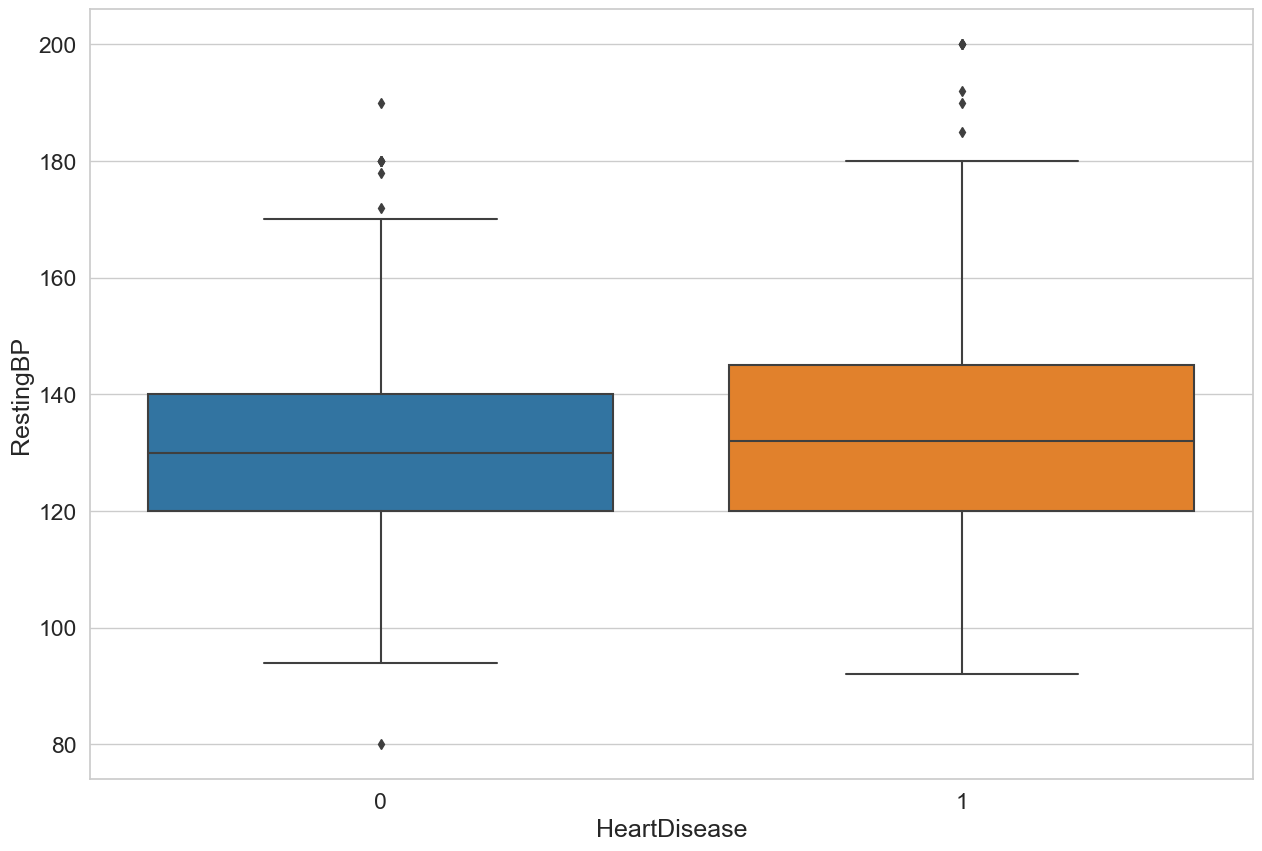

In [21]:
# boxplot of restingBP vs. Heart Disease
plt.figure(figsize=(15,10))
sns.set_context('notebook',font_scale = 1.5)
sns.boxplot(x=df['HeartDisease'], y=df['RestingBP'])
plt.savefig('figures/RestingBPAnalysisBoxplot.jpg')

The boxplot shows a slightly higher average resting blood pressure for those with heart disease. Therefore, it is hard to determine if resting blood pressure plays a significant role in indicating heart disease.

### Resting blood pressure analysis using pie charts

Count of data tuples with low blood pressure (value < 90):  1


<Figure size 2000x2000 with 0 Axes>

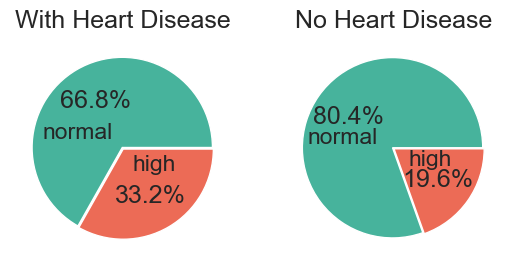

In [22]:
print("Count of data tuples with low blood pressure (value < 90): ",
      len(df[df['RestingBP'] < 90]))

normalBPD = df[(df.RestingBP<140) & (df.HeartDisease==1)]
highBPD = df[(df.RestingBP>140) & (df.HeartDisease==1)]

normalBP = df[(df.RestingBP<140) & (df.HeartDisease==0)]
highBP = df[(df.RestingBP>140) & (df.HeartDisease==0)]

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(normalBPD),len(highBPD)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(normalBP),len(highBP)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/RestingBPAnalysisPie.jpg')

Since there is only 1 data tuple belonging to low blood pressure threshold (less than 90), we include this data tuple in the normal blood pressure group.

The pie chart shows that the percentage of individuals with high blood pressure (33.2%) is much higher than that with low blood pressure (19.6%). It performs better at showing the high blood pressure as an important feature in heart disease diagnosis.

### Cholesterol analysis

Count of data tuples with missing values for Cholesterol:  171
Subset dataframe by removing data tuples with missing values.
New dataframe shape:  (746, 12)


<Figure size 2000x2000 with 0 Axes>

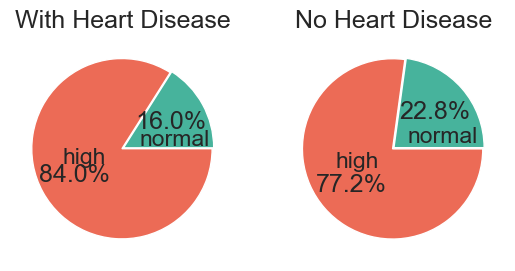

In [23]:
# Analyze cholesterol
print('Count of data tuples with missing values for Cholesterol: ',len(df[df['Cholesterol']==0]))
complete_cho = df[df['Cholesterol']!=0]
print('Subset dataframe by removing data tuples with missing values.')
print('New dataframe shape: ',complete_cho.shape)

normalCD = complete_cho[(complete_cho.Cholesterol<200) & (complete_cho.HeartDisease==1)]
highCD = complete_cho[(complete_cho.Cholesterol>=200) & (complete_cho.HeartDisease==1)]

normalC = complete_cho[(complete_cho.Cholesterol<200) & (complete_cho.HeartDisease==0)]
highC = complete_cho[(complete_cho.Cholesterol>=200) & (complete_cho.HeartDisease==0)]

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(normalCD),len(highCD)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(normalC),len(highC)],labels=['normal','high'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/CholesterolAnalysis.jpg')

The number of data tuples with missing values for Cholesterol accounts for 18.6% of the total dataset. We first would like to discard these data tuples and use the pie charts to rule out any relationship between this feature and heart disease diagnosis. The pie charts suggest that individuals with heart disease tend to also have high cholesterol (84%), as compared to the group with no heart disease (77.2%) It indicates that cholesterol plays an important role in heart disease diagnosis.

### Fasting blood sugar analysis

Count of individuals having low fasting blood sugar:  703


<Figure size 2000x2000 with 0 Axes>

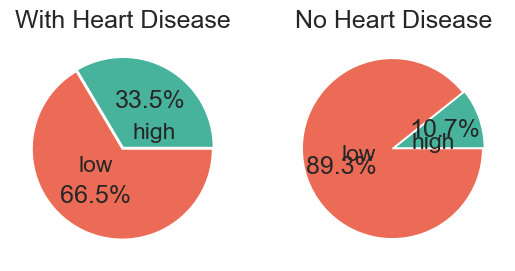

In [24]:
# Fasting blood sugar analysis
highfbsD = df[(df.FastingBS==1) & (df.HeartDisease==1)]
lowfbsD = df[(df.FastingBS==0) & (df.HeartDisease==1)]

highfbs = df[(df.FastingBS==1) & (df.HeartDisease==0)]
lowfbs = df[(df.FastingBS==0) & (df.HeartDisease==0)]

print("Count of individuals having low fasting blood sugar: ", len(lowfbsD) + len(lowfbs))

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(highfbsD),len(lowfbsD)],labels=['high','low'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(highfbs),len(lowfbs)],labels=['high','low'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/FastingBSAnalysis.jpg')

From the pie charts, both show similar trend that individuals having low fasting take the majority. The explanation for such a result is that the data consists out 703 individuals with low fasting blood pressure (76.7% of total data tuples). Due to the skewed size of the dataset, we cannot draw any clear conclusion based on the pie charts alone.

### Resting electro-cardiograph (ECG) analysis

<Figure size 5000x4000 with 0 Axes>

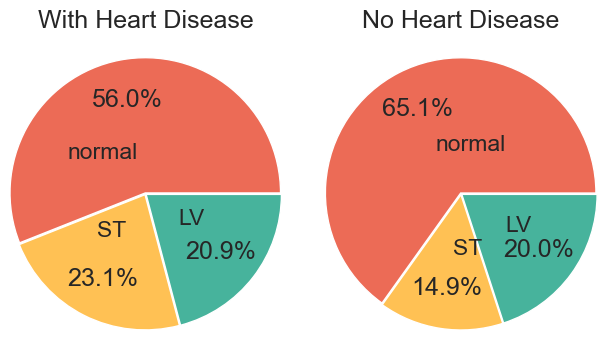

In [25]:
normalD = df[(df.RestingECG==0) & (df.HeartDisease==1)]
stD = df[(df.RestingECG==1)&(df.HeartDisease==1)]
lvD = df[(df.RestingECG==2)&(df.HeartDisease==1)]

normal = df[(df.RestingECG==0) & (df.HeartDisease==0)]
st = df[(df.RestingECG==1)&(df.HeartDisease==0)]
lv = df[(df.RestingECG==2)&(df.HeartDisease==0)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(50,40))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(normalD),len(stD),len(lvD)],labels=['normal','ST','LV'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.3,center=(0,0))
ax[0].set_title('With Heart Disease', y=1.2, x=0.3)
ax[1].pie([len(normal),len(st),len(lv)],labels=['normal','ST','LV'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.5, pctdistance = 0.7, labeldistance=0.4, center=(0.5,0))
ax[1].set_title('No Heart Disease', y=1.2)
plt.savefig('figures/RestingECGAnalysis.jpg')

For individuals with normal resting ECG, there is no significant difference between the groups with and without heart disease. This finding is consistent with individuals with left ventricular hypertrophy. However, individuals with ST-T wave abnormality shows a higher percentage for those with heart disease. This finding indicates that resting ECG might take part in diagnosign heart disease.

### Max heart rate (HR) analysis

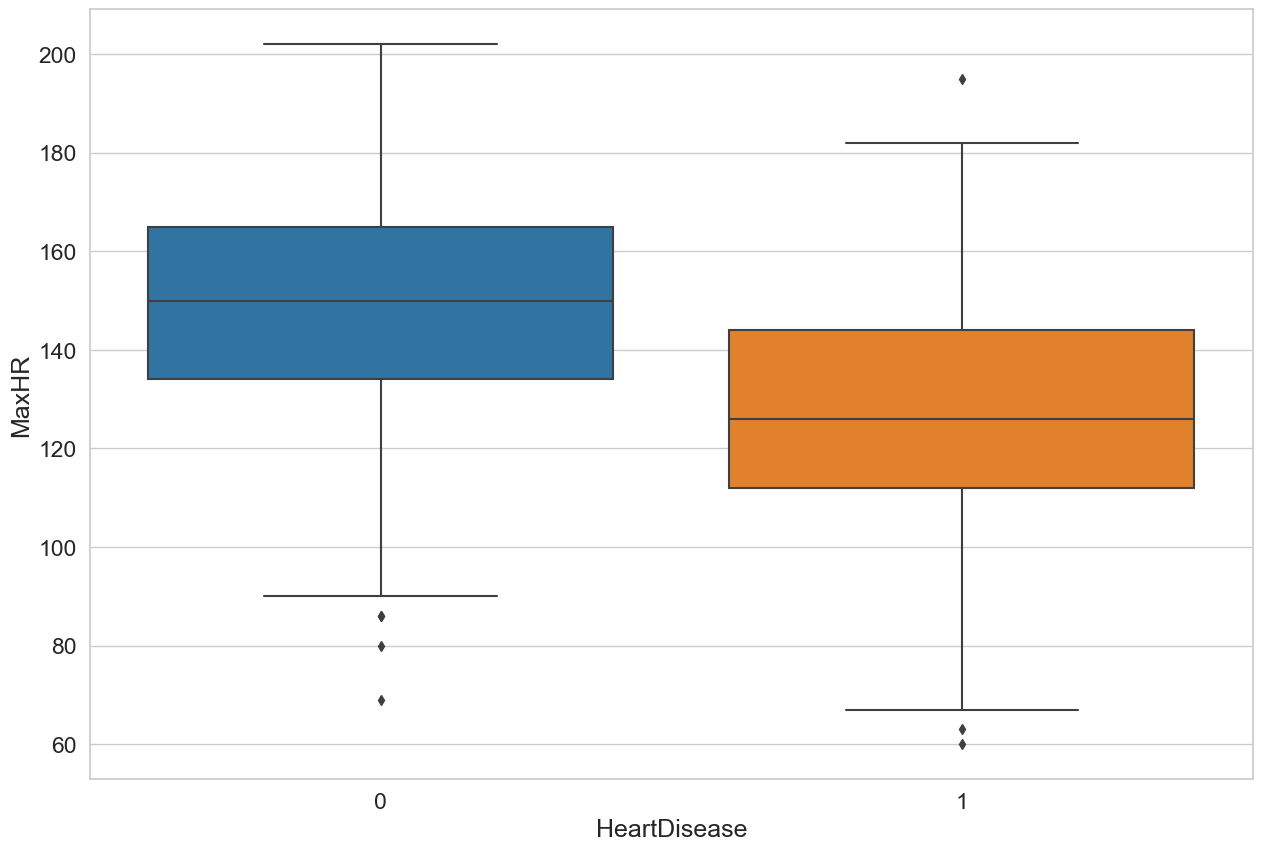

In [26]:
# boxplot of MaxHR vs. Heart Disease
plt.figure(figsize=(15,10))
sns.set_context('notebook',font_scale = 1.5)
sns.boxplot(x=df['HeartDisease'], y=df['MaxHR'])
plt.savefig('figures/MaxHRAnalysis.jpg')

The boxplot clearly shows that individuals with heart disease have a higher maximum heart rate on average (150), as compared to those with no heart disease (130). This finding indicates the maximum heart rate feature takes an important role in diagnosing heart disease.

### Exercise angina analysis

<Figure size 2000x2000 with 0 Axes>

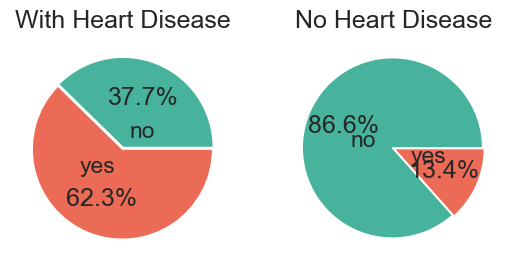

In [27]:
eanD = df[(df.ExerciseAngina==0) & (df.HeartDisease==1)]
eayD = df[(df.ExerciseAngina==1) & (df.HeartDisease==1)]

ean = df[(df.ExerciseAngina==0) & (df.HeartDisease==0)]
eay = df[(df.ExerciseAngina==1) & (df.HeartDisease==0)]

colors = ['#47B39C','#EC6B56']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(eanD),len(eayD)],labels=['no','yes'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(ean),len(eay)],labels=['no','yes'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 0.2)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/ExerciseAnginaAnalysis.jpg')

The pie charts clearly illustrate that individuals who experience exercise angina have a higher chance of carrying heart disease (62.3% vs. 13.4%. This finding shows a significant impact of exercise angina in diagnosing heart disease.

### Oldpeak analysis

<Figure size 2000x2000 with 0 Axes>

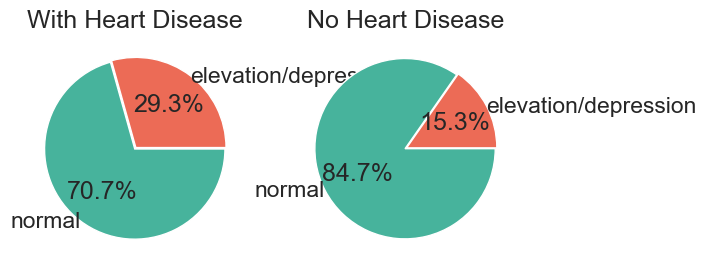

In [28]:
# Pie chart for oldpeak (ST depression induced by exercise relative to rest)
stedD = df[(df.Oldpeak<-0.1) | (df.Oldpeak>0.1) & (df.HeartDisease==1)]
normalD = df[(df.Oldpeak>=-0.1) | (df.Oldpeak<=0.1) & (df.HeartDisease==1)]

sted = df[(df.Oldpeak<-0.1) | (df.Oldpeak>0.1) & (df.HeartDisease==0)]
normal = df[(df.Oldpeak>=-0.1) | (df.Oldpeak<=0.1) & (df.HeartDisease==0)]

colors = ['#EC6B56', '#47B39C']
plt.figure(figsize=(20,20))
sns.set_context('notebook',font_scale = 1.5)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(stedD),len(normalD)],labels=['elevation/depression','normal'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 1)
ax[0].set_title('With Heart Disease')
ax[1].pie([len(sted),len(normal)],labels=['elevation/depression','normal'],colors=colors, explode= [0.01,0.01], autopct='%1.1f%%', labeldistance = 1)
ax[1].set_title('No Heart Disease')
plt.savefig('figures/OldpeakAnalysis.jpg')

According to the literature, the normal range from ST depression and elevation is between -0.1 and 0.1. Any values outside this range is considered to be abnormal. The pie charts show that the percentage of individuals with heart disease have their oldpeak in the abnormal range, is higher than those who don't have heart diseases. It is congruent with the literature, regarding ST depression and elevation.

### ST_Slope analysis

<Figure size 5000x2000 with 0 Axes>

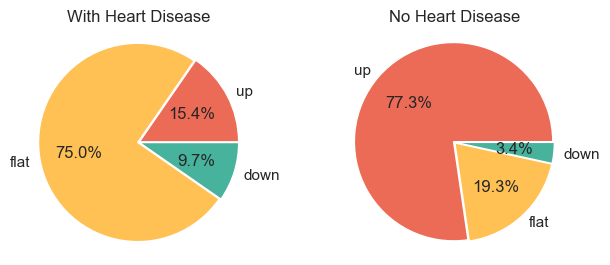

In [29]:
# Plot pie chart for ST slope vs. heart disease
upD = df[(df.ST_Slope==0) & (df.HeartDisease==1)]
flatD = df[(df.ST_Slope==1)&(df.HeartDisease==1)]
downD = df[(df.ST_Slope==2)&(df.HeartDisease==1)]

up = df[(df.ST_Slope==0) & (df.HeartDisease==0)]
flat = df[(df.ST_Slope==1)&(df.HeartDisease==0)]
down = df[(df.ST_Slope==2)&(df.HeartDisease==0)]

colors = ['#EC6B56','#FFC154','#47B39C']
plt.figure(figsize=(50,20))
sns.set_context('notebook',font_scale = 1)
fig, ax = plt.subplots(1,2, sharex='all', sharey='all')

ax[0].pie([len(upD),len(flatD),len(downD)],labels=['up','flat','down'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.1, pctdistance = 0.6, labeldistance=1.1,center=(0,0))
ax[0].set_title('With Heart Disease', y=1, x=0.3)
ax[1].pie([len(up),len(flat),len(down)],labels=['up','flat','down'],colors=colors, explode= [0.01,0.01,0.01], autopct='%1.1f%%', radius = 1.1, pctdistance = 0.6, labeldistance=1.1, center=(0.5,0))
ax[1].set_title('No Heart Disease', y=1)
plt.savefig('figures/STSlopeAnalysis.jpg')

From the pie charts, we can see that individuals with heart disease tend to have flat ST slope (the slope of peak exercise ST segment). On other hand, up ST slope is associated with individuals experiencing no heart disease.

### Create dummy columns for each categorical variables

In [30]:
# Create dummies columns for categorical variable, to be used for machine learning algorithm
df = pd.get_dummies(df, columns = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
print(df.head())


   Age  RestingBP  Cholesterol  MaxHR  Oldpeak  HeartDisease  Sex_0  Sex_1  \
0   40        140          289    172      0.0             0      1      0   
1   49        160          180    156      1.0             1      0      1   
2   37        130          283     98      0.0             0      1      0   
3   48        138          214    108      1.5             1      0      1   
4   54        150          195    122      0.0             0      1      0   

   ChestPainType_0  ChestPainType_1  ...  FastingBS_0  FastingBS_1  \
0                1                0  ...            1            0   
1                0                1  ...            1            0   
2                1                0  ...            1            0   
3                0                0  ...            1            0   
4                0                1  ...            1            0   

   RestingECG_0  RestingECG_1  RestingECG_2  ExerciseAngina_0  \
0             1             0             0  

The dummies columns are created for each categorical variable. The dataset now contains 22 columns.

### Normalize all continuous variable using MinMaxScaler

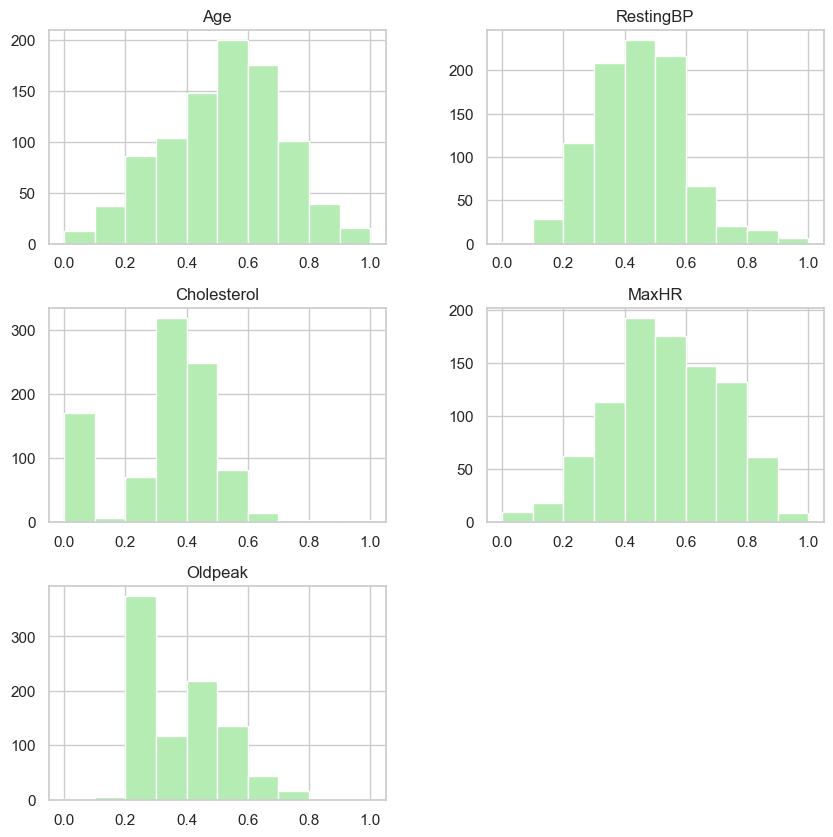

In [31]:
# Scale continuous variables to range [0,1]
scaler = MinMaxScaler()
columns_to_scale = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']
df[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
df[columns_to_scale].hist(figsize=(10,10), color = '#B5ECB3')
plt.savefig('figures/Normalized.jpg')

The range for each continuous variable is within range [0,1] as expected.

### Filling missing values for cholesterol using MICE Imputation

In [32]:
print('Total count of cholesterol with value 0 before: ',len(df[df['Cholesterol']==0]))
df_imputed = df.copy(deep=True)
df_imputed.loc[ df_imputed['Cholesterol'] == 0, 'Cholesterol'] = np.nan
print('Total count of cholesterol with value 0 after: ',len(df_imputed[df_imputed['Cholesterol']==0]))
print('Total missing values (NaN): ',df_imputed['Cholesterol'].isna().sum())

Total count of cholesterol with value 0 before:  171
Total count of cholesterol with value 0 after:  0
Total missing values (NaN):  171


In [33]:
# df_knn_imputed = df_imputed.copy(deep=True)
# knn_imputer = KNNImputer()
# df_knn_imputed['Cholesterol'] = knn_imputer.fit_transform(df_knn_imputed)
# df_knn_imputed['Cholesterol'].hist(figsize=(5,5), color = '#B5ECB3')

Total missing values (NaN):  0


<AxesSubplot: >

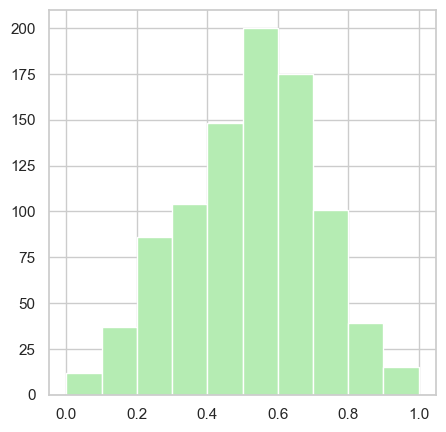

In [34]:
df_mice_imputed = df_imputed.copy(deep=True)
mice_imputer = IterativeImputer()
df_mice_imputed['Cholesterol'] = mice_imputer.fit_transform(df_mice_imputed)
print('Total missing values (NaN): ',df_mice_imputed['Cholesterol'].isna().sum())
df_mice_imputed['Cholesterol'].hist(figsize=(5,5), color = '#B5ECB3')

### Split the dataset into training and testing set

In [35]:
# # Let's say we want to split the data in 70:15:15 for train:valid:test dataset
# train_size = 0.7
#
# X = df_mice_imputed.drop(columns = ['HeartDisease']).copy()
# y = df_mice_imputed['HeartDisease']
#
# # In the first step we will split the data in training and remaining dataset
# X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=train_size)
#
# # Now since we want the valid and test size to be equal (15% each of overall data).
# # we have to define valid_size=0.5 (that is 50% of remaining data)
# test_size = 0.5
# X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=test_size)
#
# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)

In [36]:
X = df_mice_imputed.drop(columns = ['HeartDisease']).copy()
y = df_mice_imputed['HeartDisease']

X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)

(733, 21)
(733,)
(184, 21)
(184,)


(None, None)

In [37]:
# X_train, y_train, X_valid, y_valid, X_test, y_test = train_valid_test_split(df_mice_imputed, target = 'HeartDisease', train_size=0.7, valid_size=0.2, test_size=0.1)
#
# print(X_train.shape), print(y_train.shape)
# print(X_valid.shape), print(y_valid.shape)
# print(X_test.shape), print(y_test.shape)


In [38]:
#feature_names = X_train.columns.values.tolist()
feature_names = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak', 'Sex (Male)', 'Sex (Female)', 'ChestPainType (ATA)', 'ChestPainType (NAP)', 'ChestPainType (ASY)', 'ChestPainType (TA)', 'FastingBS (Low)', 'FastingBS (High)', 'RestingECG (Normal)', 'RestingECG (ST)', 'Resting(LVH)', 'ExerciseAngina (No)', 'ExerciseAngina (Yes)', 'ST_Slope (Up)', 'ST_Slope (Flat)', 'ST_Slope (Down)']
# a function to plot a bar graph of important features
def plot_feature_importances(clf, feature_names):
    c_features = len(feature_names)
    plt.barh(range(c_features), clf.feature_importances_)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature name")
    plt.yticks(np.arange(c_features), feature_names)


### Decision Tree classifier accuracy for training and testing set

In [39]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth = 6, min_samples_leaf = 8,
                            random_state = 0).fit(X_train, y_train)

print('Accuracy of DT classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of DT classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))


Accuracy of DT classifier on training set: 0.88
Accuracy of DT classifier on test set: 0.83


### Feature importance

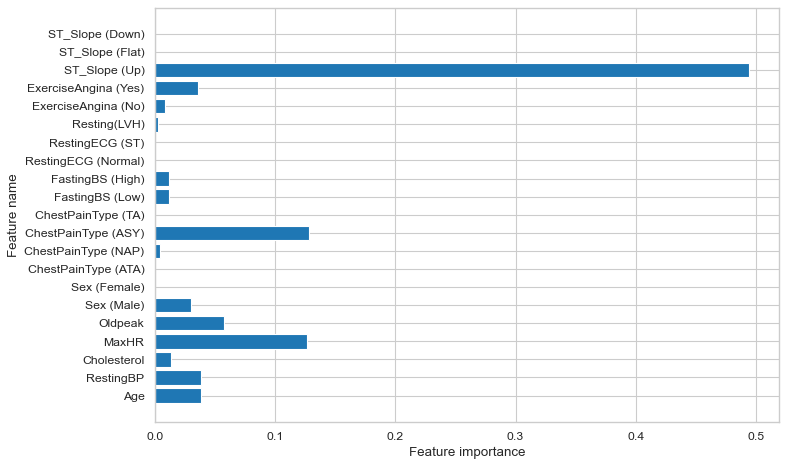

In [40]:
plt.figure(figsize=(10,6),dpi=80)
plot_feature_importances(clf, feature_names)
plt.tight_layout()

plt.show()

### Decision Tree Visualization

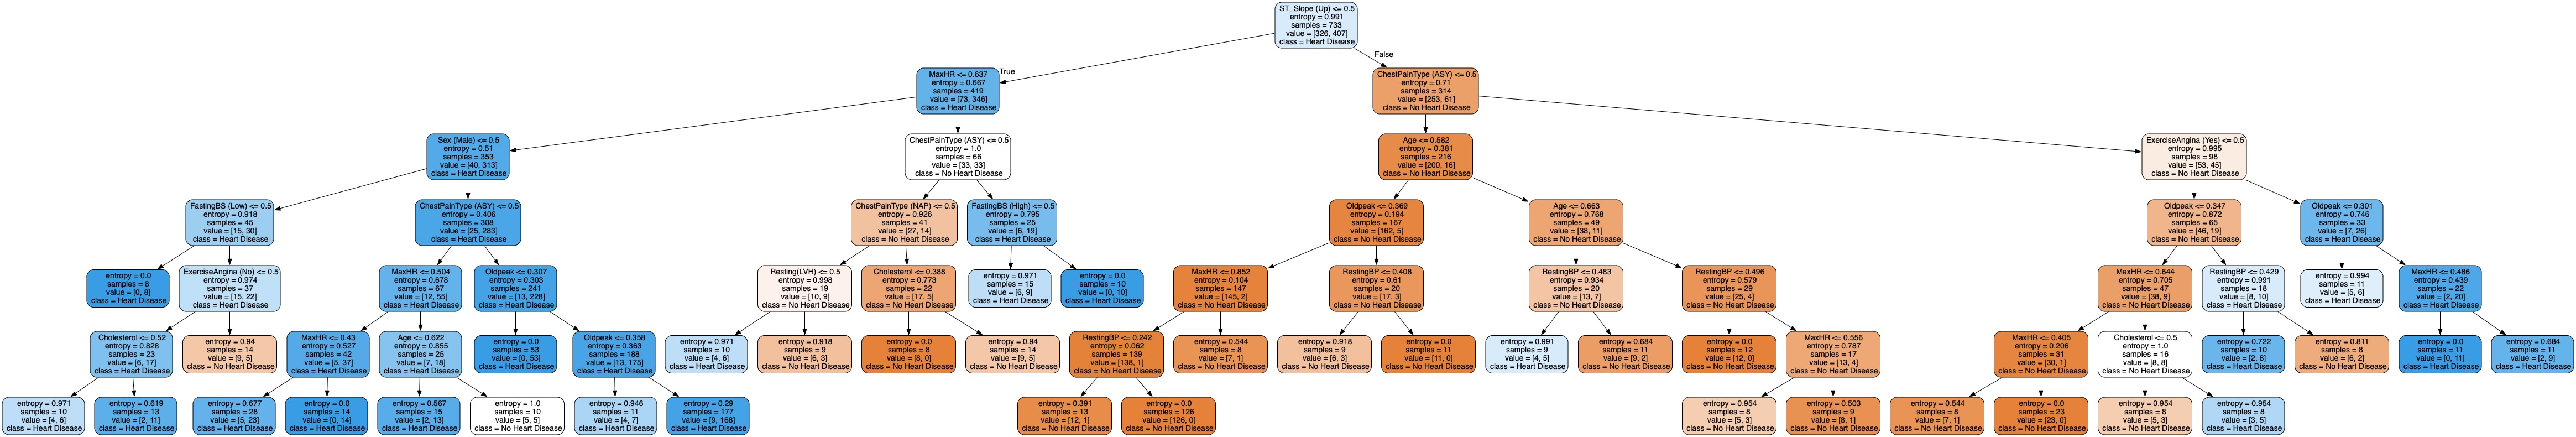

In [41]:
# feature_names = X_train.columns.values.tolist()
#print(feature_names)
target_names = ['No Heart Disease', 'Heart Disease']
export_graphviz(
        clf,
        out_file=os.path.join(IMAGES_PATH, "dt.dot"),
        feature_names=feature_names,
        class_names=target_names,
        rounded=True,
        filled=True
    )
#graphviz.view('images/decision_trees/dt.dot')
graphviz.render('dot', filepath='images/decision_trees/dt.dot', outfile='images/decision_trees/DecisionTree.jpg')
Image(filename='images/decision_trees/DecisionTree.jpg')
#Source.from_file(os.path.join(IMAGES_PATH, "dt.dot"))

### Regression

### K-Fold Validation for DT hyperparameter tuning

#### Performance metrics calculation

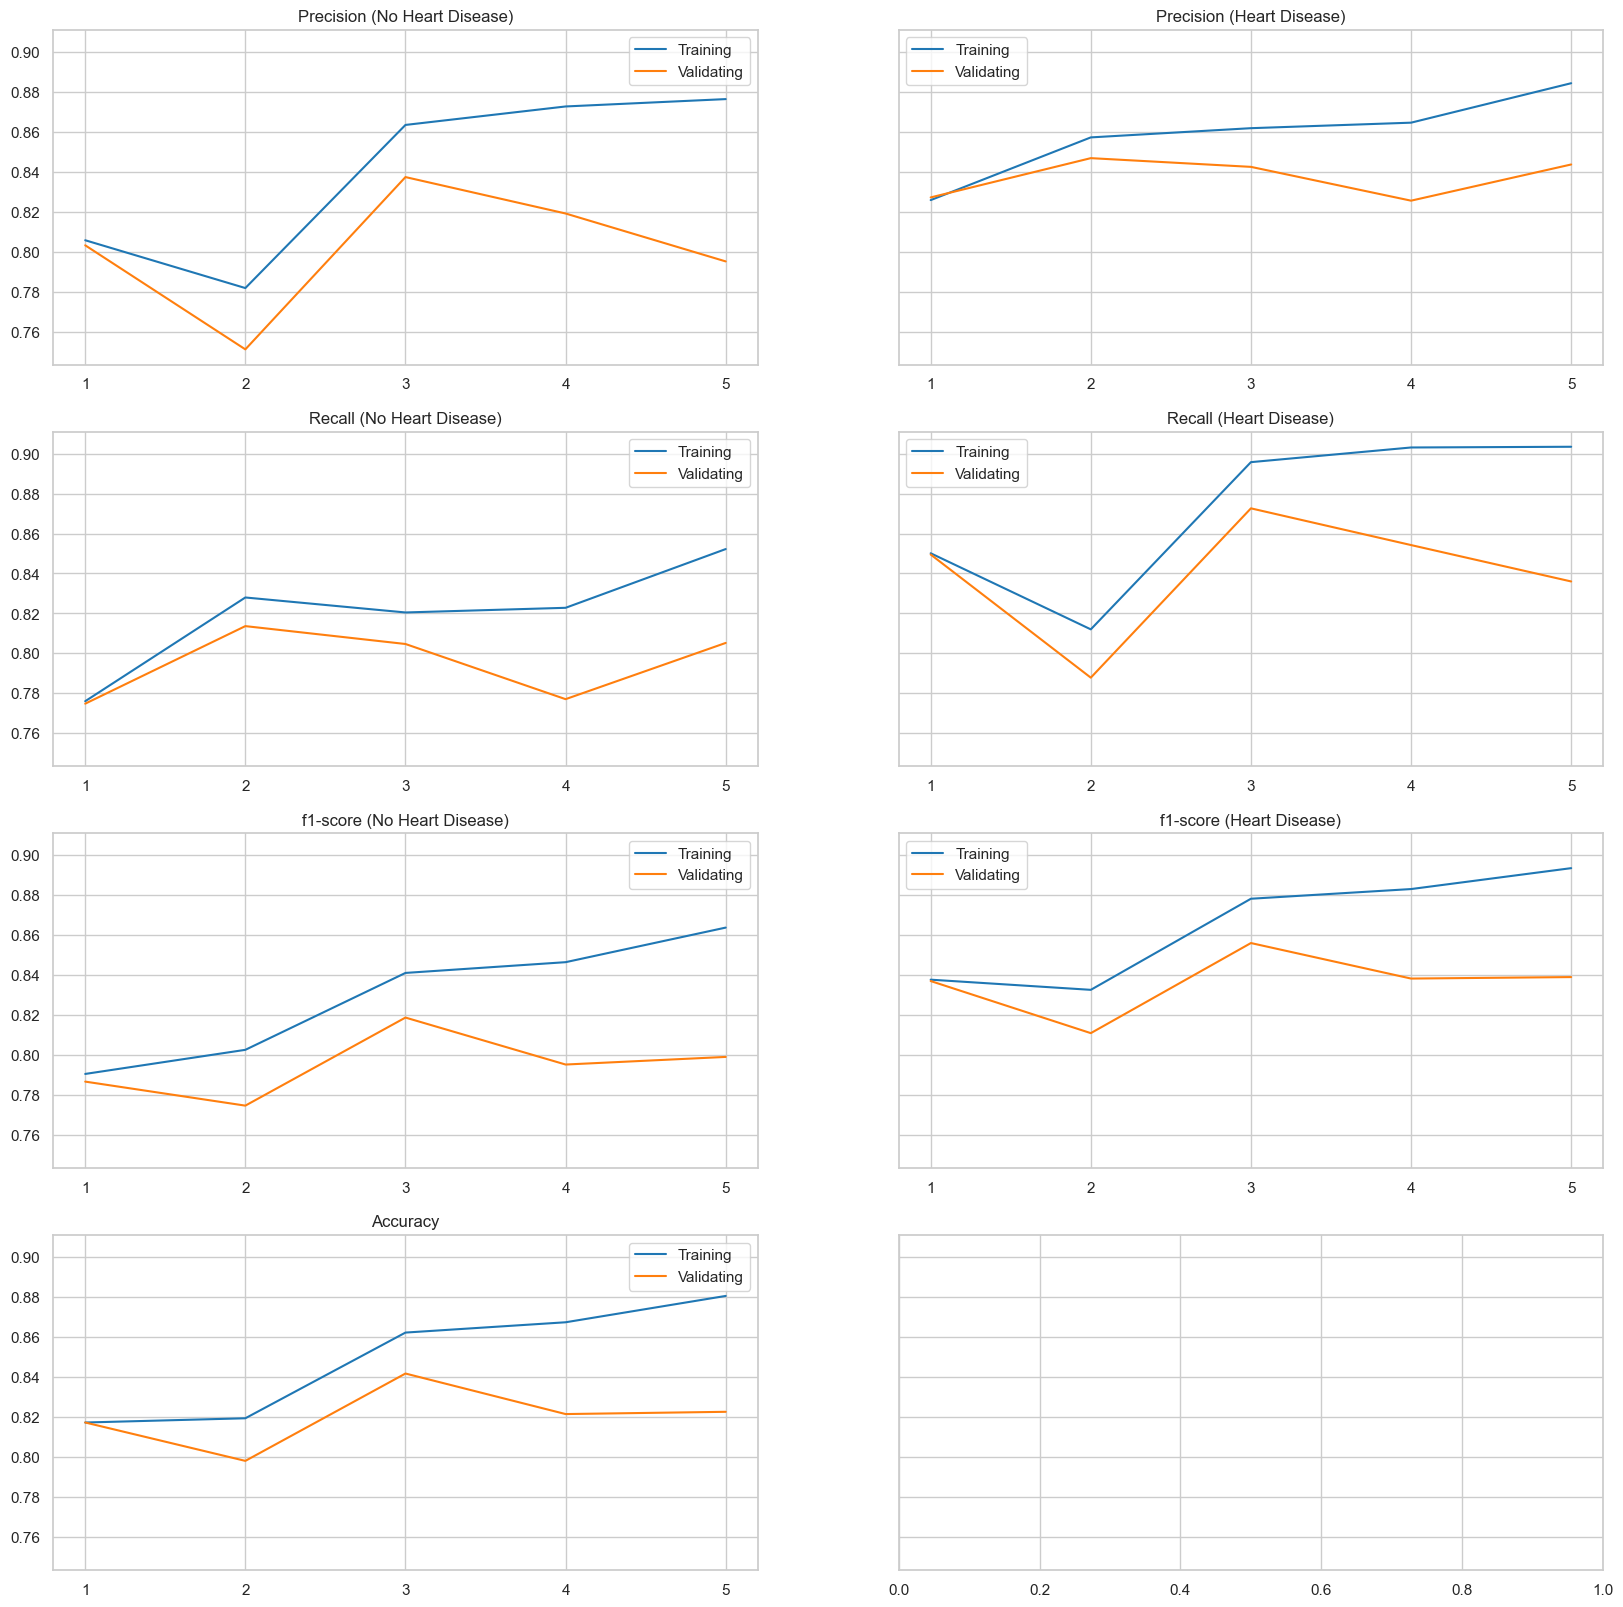

In [42]:
k = 10
kf = KFold(n_splits=k, random_state=None, shuffle=True) # Define the split - into 4 folds

header = ['Set', 'Parameter', 'Value', 'Accuracy', 'Precision (No)', 'Precision (Yes)', 'Recall (No)', 'Recall (Yes)', 'f1-score (No)', 'f1-score (Yes)']

decision_tree = pd.DataFrame(columns=header)

for i in range (1,6):
    dt_clf = DecisionTreeClassifier(criterion='entropy', max_depth = i, min_samples_leaf = 8,
                            random_state = 0)

    # validating set variables
    accuracy_val = 0

    no_precision_val = 0
    yes_precision_val = 0

    no_recall_val = 0
    yes_recall_val = 0

    no_f1_val = 0
    yes_f1_val = 0

    # mac_avg_precision_val = 0
    # mac_avg_recall_val = 0
    # mac_avg_f1_val = 0
    #
    # w_avg_precision_val = 0
    # w_avg_recall_val = 0
    # w_avg_f1_val = 0

    # validating set variables
    accuracy_tra = 0

    no_precision_tra = 0
    yes_precision_tra = 0

    no_recall_tra = 0
    yes_recall_tra = 0

    no_f1_tra = 0
    yes_f1_tra = 0

    # mac_avg_precision_tra = 0
    # mac_avg_recall_tra = 0
    # mac_avg_f1_tra = 0
    #
    # w_avg_precision_tra = 0
    # w_avg_recall_tra = 0
    # w_avg_f1_tra = 0

    # I think kfold should be performed on Training set
    for train_index, test_index in kf.split(X_train, y_train):
        #print("TRAIN:", train_index, "TEST:", test_index)
        # Change pandas dataframe to numpy array
        X_tra, X_val = X_train.iloc[train_index], X_train.iloc[test_index]
        y_tra, y_val = y_train.iloc[train_index], y_train.iloc[test_index]

        # fit model using the training set
        dt_clf.fit(X_tra, y_tra)
        # compute predicted values for training set
        y_pred_tra = dt_clf.predict(X_tra)
        # compute predicted values for validating set
        y_pred_val = dt_clf.predict(X_val)

        # Print classification report for training set
        result_metrics_tra = classification_report(y_tra, y_pred_tra, target_names=target_names)
        # For validating set
        result_metrics_val = classification_report(y_val, y_pred_val, target_names=target_names)

        #print(result_metrics_val)

        # Once you get dictionary of metrics, access the values using dictionary
        result_metrics_tra_dict = classification_report(y_tra, y_pred_tra, target_names=target_names, output_dict=True)
        result_metrics_val_dict = classification_report(y_val, y_pred_val, target_names=target_names, output_dict=True)


        # print(result_metrics_dict)
        # Todo: create a copy of accumulation for training
        # Todo: rename the variable to no yes

        # this is an example to accumulate a measure for training
        accuracy_tra += result_metrics_tra_dict['accuracy']

        no_precision_tra += result_metrics_tra_dict['No Heart Disease']['precision']
        yes_precision_tra += result_metrics_tra_dict['Heart Disease']['precision']

        no_recall_tra += result_metrics_tra_dict['No Heart Disease']['recall']
        yes_recall_tra += result_metrics_tra_dict['Heart Disease']['recall']

        no_f1_tra += result_metrics_tra_dict['No Heart Disease']['f1-score']
        yes_f1_tra += result_metrics_tra_dict['Heart Disease']['f1-score']


        # mac_avg_precision_tra += result_metrics_tra_dict['macro avg']['precision']
        # mac_avg_recall_tra += result_metrics_tra_dict['macro avg']['recall']
        # mac_avg_f1_tra += result_metrics_tra_dict['macro avg']['f1-score']
        #
        # w_avg_precision_tra += result_metrics_tra_dict['weighted avg']['precision']
        # w_avg_recall_tra += result_metrics_tra_dict['weighted avg']['recall']
        # w_avg_f1_tra += result_metrics_tra_dict['weighted avg']['f1-score']

        # this is an example to accumulate a measure for validating
        accuracy_val += result_metrics_val_dict['accuracy']

        no_precision_val += result_metrics_val_dict['No Heart Disease']['precision']
        yes_precision_val += result_metrics_val_dict['Heart Disease']['precision']

        no_recall_val += result_metrics_val_dict['No Heart Disease']['recall']
        yes_recall_val += result_metrics_val_dict['Heart Disease']['recall']

        no_f1_val += result_metrics_val_dict['No Heart Disease']['f1-score']
        yes_f1_val += result_metrics_val_dict['Heart Disease']['f1-score']

        # mac_avg_precision_val += result_metrics_val_dict['macro avg']['precision']
        # mac_avg_recall_val += result_metrics_val_dict['macro avg']['recall']
        # mac_avg_f1_val += result_metrics_val_dict['macro avg']['f1-score']
        #
        # w_avg_precision_val += result_metrics_val_dict['weighted avg']['precision']
        # w_avg_recall_val += result_metrics_val_dict['weighted avg']['recall']
        # w_avg_f1_val += result_metrics_val_dict['weighted avg']['f1-score']

    # Obtain list and append to the DataFrame decision_tree for each iteration for i
    data_tra = ['Training', 'max_depth', int(i), accuracy_tra/k, no_precision_tra/k, yes_precision_tra/k, no_recall_tra/k, yes_recall_tra/k, no_f1_tra/k, yes_f1_tra/k]
    data_val = ['Validating', 'max_depth', int(i), accuracy_val/k, no_precision_val/k, yes_precision_val/k, no_recall_val/k, yes_recall_val/k, no_f1_val/k, yes_f1_val/k]
    decision_tree.loc[len(decision_tree)] = data_tra
    decision_tree.loc[len(decision_tree)] = data_val

# sort the decision_tree DataFrame
decision_tree.sort_values(by=['Set', 'Value'], inplace=True)

# Export to .csv file
decision_tree.to_csv('data/decision_tree.csv')

dt_tra = decision_tree[decision_tree['Set']=='Training']
dt_val = decision_tree[decision_tree['Set']=='Validating']

fig, ax = plt.subplots(4,2, sharey='all', figsize=(20, 20))

ax[0, 0].plot(dt_tra['Value'], dt_tra['Precision (No)'], label='Training')
ax[0, 0].plot(dt_val['Value'], dt_val['Precision (No)'], label='Validating')
ax[0, 0].legend()
ax[0, 0].set_title('Precision (No Heart Disease)')
ax[0, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[0, 1].plot(dt_tra['Value'], dt_tra['Precision (Yes)'], label='Training')
ax[0, 1].plot(dt_val['Value'], dt_val['Precision (Yes)'], label='Validating')
ax[0, 1].legend()
ax[0, 1].set_title('Precision (Heart Disease)')
ax[0, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1, 0].plot(dt_tra['Value'], dt_tra['Recall (No)'], label='Training')
ax[1, 0].plot(dt_val['Value'], dt_val['Recall (No)'], label='Validating')
ax[1, 0].legend()
ax[1, 0].set_title('Recall (No Heart Disease)')
ax[1, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[1, 1].plot(dt_tra['Value'], dt_tra['Recall (Yes)'], label='Training')
ax[1, 1].plot(dt_val['Value'], dt_val['Recall (Yes)'], label='Validating')
ax[1, 1].legend()
ax[1, 1].set_title('Recall (Heart Disease)')
ax[1, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[2, 0].plot(dt_tra['Value'], dt_tra['f1-score (No)'], label='Training')
ax[2, 0].plot(dt_val['Value'], dt_val['f1-score (No)'], label='Validating')
ax[2, 0].legend()
ax[2, 0].set_title('f1-score (No Heart Disease)')
ax[2, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[2, 1].plot(dt_tra['Value'], dt_tra['f1-score (Yes)'], label='Training')
ax[2, 1].plot(dt_val['Value'], dt_val['f1-score (Yes)'], label='Validating')
ax[2, 1].legend()
ax[2, 1].set_title('f1-score (Heart Disease)')
ax[2, 1].xaxis.set_major_locator(MaxNLocator(integer=True))

ax[3, 0].plot(dt_tra['Value'], dt_tra['Accuracy'], label='Training')
ax[3, 0].plot(dt_val['Value'], dt_val['Accuracy'], label='Validating')
ax[3, 0].legend()
ax[3, 0].set_title('Accuracy')
ax[3, 0].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.savefig('tuning/dt_max_depth.jpg')

### To do for group project
   1. Select a hyperparameter for each individual algorithm ( k for kNN, max_depth for DT)
   2. Run an outer loop for iteration of these hyperparameter for each algorithm (DT, SVM, kNN, RF)
   3. Run inner loop using kFold (1 algorithm) to find out average values for all performance metrics for both training set and validating set, record them in .csv file, and plot a line graph to show the changes between these values for each iteration of the hyperparameter. (This can be seperated between team members, since we have 4 algorithms to tune the hyperparameter.
   4. Select the best hyperparameter for each individual algorithm, and run a kFole loop with all 4 algorithms against the testing set, and then compare the average results for all performance metrics between 4 algorithms